# LunarLande-v2

Second part of the homework. Implementing a reinforcement agent deep network to train the $LunarLander-v2$ of the gym environement

In [1]:
%%capture
!pip install -q gwpy


!pip install gym
!apt update
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip3 install box2d-py
!pip3 install gym[Box_2D]
!python -m pip uninstall matplotlib -y
!pip install matplotlib==3.1.3

In [2]:
import gym
from gym import wrappers
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import HTML
import torch
import torch.nn as nn
import torch.nn.functional as F
import glob
import io
import base64
import os
from tqdm.notebook import tqdm
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor
%matplotlib inline

In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [4]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [5]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

In [6]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append( (state, action, next_state, reward) ) # Add the tuple (state, action, next_state, reward) to the queue

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

In [7]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 128),
            nn.Tanh(),
            nn.Linear(128,256),
            nn.Tanh(),
            nn.Linear(256,128),
            nn.Tanh(),
            nn.Linear(128,action_space_dim),
                )

    def forward(self, x):
        return self.linear(x)

In [8]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

In [9]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

In [10]:
# Define an example network
net = DQN(state_space_dim=8, action_space_dim=4) #2 output = lef or right

Text(0, 0.5, 'Exploration profile (Softmax temperature)')

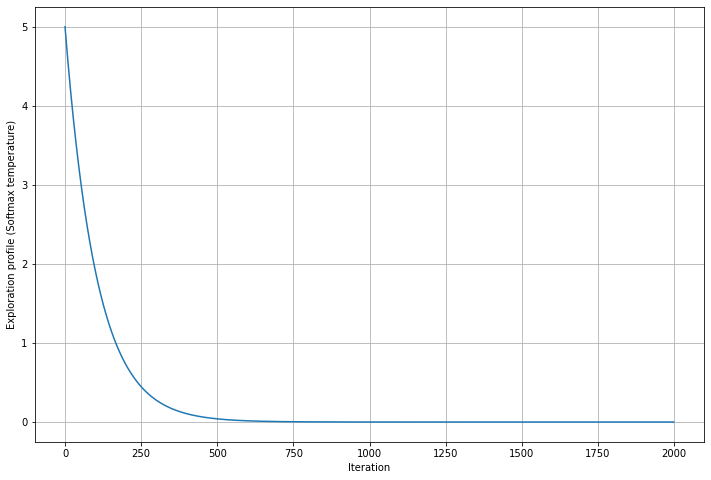

In [11]:
### Define exploration profile
initial_value = 5
#num_iterations = 1000
num_iterations = 2000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 12) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
plt.figure(figsize=(12,8))
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('Exploration profile (Softmax temperature)')

In [12]:
### Create environment
env = gym.make('LunarLander-v2')  # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)
env.reset()

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 8
ACTION SPACE SIZE: 4


In [13]:
# Define an example network
net = DQN(state_space_dim=env.observation_space.shape[0], action_space_dim=env.action_space.n) #2 output = lef or right

In [14]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(4): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 600:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: -426.77639915177974
EPISODE 2 - FINAL SCORE: -303.2619862908431
EPISODE 3 - FINAL SCORE: -467.20332450521084
EPISODE 4 - FINAL SCORE: -349.85529706452144


In [15]:
# Set random seeds
torch.manual_seed(753)
np.random.seed(753)
random.seed(753)

### PARAMETERS
gamma = 0.999   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-3   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128  # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [16]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [17]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
        target_net.eval()
        q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

In [18]:
def initialize_networks(state_space_dim = 8, action_space_dim = 4, replay_memory_capacity = 10000, lr = 1e-3):
    
    ### Initialize the replay memory
    replay_mem = ReplayMemory(replay_memory_capacity)    

    ### Initialize the policy network
    policy_net = DQN(state_space_dim, action_space_dim)

    ### Initialize the target network with the same weights of the policy network
    target_net = DQN(state_space_dim, action_space_dim)
    target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    ### Initialize the optimizer
    optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network
    
    ### Initialize the loss function (Huber loss)
    loss_fn = nn.SmoothL1Loss()
    
    return replay_mem, policy_net, target_net, optimizer, loss_fn

In [19]:
replay_mem, policy_net, target_net, optimizer, loss_fn = initialize_networks(state_space_dim,
                                                                                action_space_dim,
                                                                                replay_memory_capacity,
                                                                                lr)

In [20]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

exp_profile_temp = []
learning_curve = []
num_epochs = []

for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    reward = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      x, y, vx, vy, angle, vangle = state[0], state[1], state[2], state[3], state[4], state[5]
      left_t, right_t = state[6], state[7]

      center_weight = 1 #giving the reward if the lander stays in the middle of the screen with angle 0
      low_weight = 0.5
      angle_weight = 1 #giving reward if the y velocity is low
      vel_weight = 0.5

      reward = reward - center_weight * np.abs(x) - low_weight * np.abs(y) - vel_weight * np.abs(vy) - angle_weight * min(0,angle)

      #if (np.abs(angle) > 0.4): #reward to remain in the upper position
        #reward += -10
      #else:
        #reward += 10

      #if (np.abs(x) < 1e-2) and (np.abs(y) < 1e-2) and (np.abs(vx)<1e-2) and (np.abs(vy)<1e-2):
        #reward += 100

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          if (np.abs(x) < 1e-2) and (np.abs(y) < 1e-2) and (left_t == 1) and (right_t == 1) and (np.abs(vx)<1e-2) and (np.abs(vy)<1e-2):
            reward += 100  #reward for completing the game
          
          else: reward += bad_state_penalty

          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state
    score = reward 

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    exp_profile_temp.append(tau)
    learning_curve.append(score)
    num_epochs.append(episode_num+1)

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL REWARD: {round(score,2)} - Temperature: {tau}") # Print the final score

env.close()

  0%|          | 0/2000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL REWARD: -101.04 - Temperature: 5.0
EPISODE: 2 - FINAL REWARD: -100.76 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL REWARD: -100.66 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL REWARD: -97.76 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL REWARD: -102.04 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL REWARD: -100.64 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL REWARD: -101.64 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL REWARD: -100.88 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL REWARD: -101.02 - Temperature: 4.628278073893115


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 10 - FINAL REWARD: -99.85 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL REWARD: -101.59 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL REWARD: -100.88 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL REWARD: -98.99 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL REWARD: -100.43 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL REWARD: -101.18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL REWARD: -100.9 - Temperature: 4.325762823966208
EPISODE: 17 - FINAL REWARD: -101.74 - Temperature: 4.284191585855951
EPISODE: 18 - FINAL REWARD: -100.95 - Temperature: 4.243019853661379
EPISODE: 19 - FINAL REWARD: -100.8 - Temperature: 4.202243788069929
EPISODE: 20 - FINAL REWARD: -100.55 - Temperature: 4.161859586665416
Updating target network...
EPISODE: 21 - FINAL REWARD: -100.55 - Temperature: 4.121863483573456
EPISODE: 22 - FINAL REWARD: -98.67 - Temperature: 4.082251749110286
EPISODE: 23 - FINAL REWARD: -99.82 - Temperature: 4.04

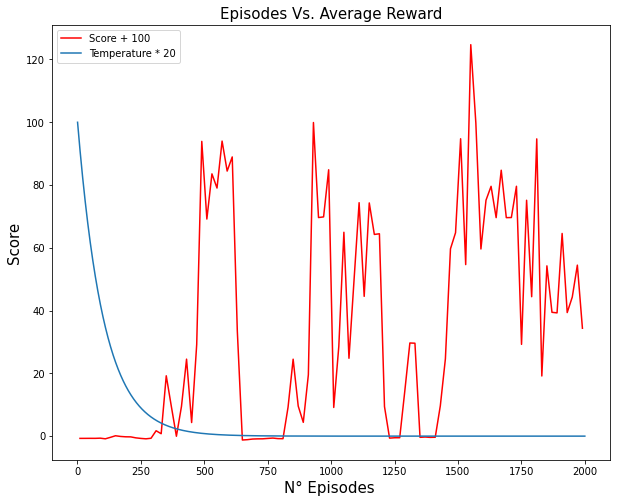

In [23]:
x=-101
t=20
m=20
plt.figure(figsize=(10,8))
#plt.plot(num_epochs[:x], np.array(learning_curve[:x])+100)
plt.plot(np.mean(np.array(num_epochs).reshape(-1,m),axis=1), np.mean(np.array(learning_curve).reshape(-1,m),axis=1)+100,color='red')
plt.plot(num_epochs, np.array(exp_profile_temp)*t)
plt.title('Episodes Vs. Average Reward',size=15)
plt.ylabel('Score',size=15)
plt.xlabel('N° Episodes ',size=15)
plt.legend(['Score + 100','Temperature * {}'.format(t)], loc='upper left')
plt.show()

In [22]:
show_videos()


SHOWING VIDEO video/openaigym.video.2.63.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000100.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000200.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000300.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000400.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000500.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000600.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000700.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000800.mp4



SHOWING VIDEO video/openaigym.video.2.63.video000900.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001000.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001100.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001200.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001300.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001400.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001500.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001600.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001700.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001800.mp4



SHOWING VIDEO video/openaigym.video.2.63.video001900.mp4


# Final Test

In [ ]:
# Initialize the Gym environment
env = gym.make('LunarLander-v2')
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
#env = wrap_env(env, "MoonLander_test_final" ,video_callable=lambda episode_id: True) # Save a video every episode
scores = []
# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score§
    print(next_state)
    scores.append(score)
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

print("Max score obtained is \t \t:", max(scores))

In [ ]:
show_videos()